# Fourth Exercise (Chapter 9)

This exercise focuses on convolutional neural networks.
We will

- implement a convolution layer
- extend the convolution with various parameters
- apply a convolutional network

You can **reuse the code you wrote in the last exercise, or you can use the code we provide (below)**.
We only adjusted the reshaping when loading the data.

**Skip forward to the exercises by clicking [here](#exercises)**.

### Base classes: `Parameter` and `Module`

In [1]:
from typing import Iterable, List, Optional, Tuple, Callable
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter but also tensors/
    properties associated with it, such as the gradient of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, name: Optional[str] = None):
        self.data = data
        self.grad = None
        self.name = name
        self.state_dict = dict()  # dict to store additional, optional information


class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None
        self.training = True

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def train(self, mode : bool = True) -> 'Module':
        """Set the module to training mode.

        This only affects some Modules, such as Dropout.
        
        Returns:
            self.
        """
        self.training = mode
        return self

    def eval(self) -> 'Module':
        """Set the module to evaluation mode.

        This only affects some Modules, such as Dropout.

        Returns:
            self.
        """
        return self.train(False)

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1.6e+15
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))



### Activation functions: `Relu` and `Softmax`

In [3]:
class Softmax(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        # Shift input for numerical stability.
        reduction_axes = tuple(range(1, len(z.shape)))
        shift_z = z - np.max(z, axis=reduction_axes, keepdims=True)
        exps = np.exp(shift_z)
        h = exps / np.sum(exps, axis=reduction_axes, keepdims=True)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


class Relu(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        return np.maximum(0, z)

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        return grad.reshape(z.shape) * np.where(z > 0, 1, 0)

### Layers

In [4]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.W = Parameter(np.random.randn(out_features, in_features) * 0.01,
                           name="W")
        self.b = Parameter(np.ones((out_features, 1)) * 0.01, name="b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        z = self.W.data @ x + self.b.data
        return z

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that we have a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of array.T
        self.W.grad += np.sum(grad @ np.transpose(x, [0, 2, 1]), axis=0)
        self.b.grad += np.sum(grad, axis=0)
        return self.W.data.T @ grad

    def parameters(self) -> List[Parameter]:
        return self.W, self.b


class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        for module in self.modules:
            x = module(x)  # equivalent to module.forward(x)
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        for module in reversed(self.modules):
            grad = module.backward(grad)
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]
    
    def train(self, mode: bool = True) -> 'Sequential':
        """Set the train mode of the Sequential module and it's sub-modules.
        
        This only affects some modules, e.g., Dropout.
        
        Returns:
            self.
        """
        for module in self.modules:
            module.train(mode)
        return self


def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 2]]
    """
    encoded = np.zeros(y.shape + (num_classes,))
    encoded[np.arange(len(y)), y] = 1
    return encoded

### Optimizers

In [5]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)


class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # update the momentum
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                # update the parameter
                p.data += p.state_dict["momentum"]
            else:
                p.data -= self.lr * p.grad

### Loss Functions


In [6]:
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        grad = (a - y) / len(a)

        # We have to recreate the batch dimension
        grad = np.expand_dims(grad, -1)
        return grad

### Training loops

In [7]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, loss_fn, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(labels, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, scheduler=None):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)

        # train for one epoch
        model.train()
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            optimizer.zero_grad()
            y_batch_predicted = model(x_batch)
            h_1 = np.squeeze(y_batch_predicted)
            training_predictions.append(h_1)
            loss = loss_fn(h_1, y_batch)
            grad = loss_fn.backward()
            model.backward(grad)
            optimizer.step()
            train_costs[epoch] += loss
        if scheduler:
            scheduler.step()
        model.eval()
    
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, loss_fn, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

### Data Loading

In [8]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = x_train.reshape(-1, 1, 28, 28)
x_val = x_val.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

<a id='exercises'></a>
# Exercises

## Warmup

### Pytorch installation

 [*PyTorch*](https://pytorch.org/) is a grown-up python library for deep learning. It provides modules like the ones we implemented in the previous exercises and many more. We tried to keep the interface similar, so you will already feel at home when using PyTorch. In contrast to our own implementation, when using pytorch you only have to implement the forward pass - the backward pass will be calculated automagically. 
 
In this exercise you have to install pytorch and verify the correct installation. 
We will use pytorch to verify the correctness of our own convolutional network implementation (next exercise part). In the next exercises, we will use pytorch more and more. 

**Task:** [Install PyTorch](https://pytorch.org/get-started/locally/) and run the code below.

In [9]:
import torch
import torch.nn as nn


model = nn.Sequential(
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10))

input = torch.randn(50, 1, 1, 100)
output = model(input)

input.shape, model, output.shape

(torch.Size([50, 1, 1, 100]), Sequential(
   (0): Linear(in_features=100, out_features=30, bias=True)
   (1): ReLU()
   (2): Linear(in_features=30, out_features=10, bias=True)
 ), torch.Size([50, 1, 1, 10]))

### Image Dataset

With convolutions, we finally can see the MNIST data samples as what they are: greyscale images. 
Instead of flattened features, we load them in 2d shape `x_train.shape == (n_samples, channels, width, height) == (50000, 1, 28, 28)`. 

**Task:** Plot 20 of the samples as *greyscale* images below.

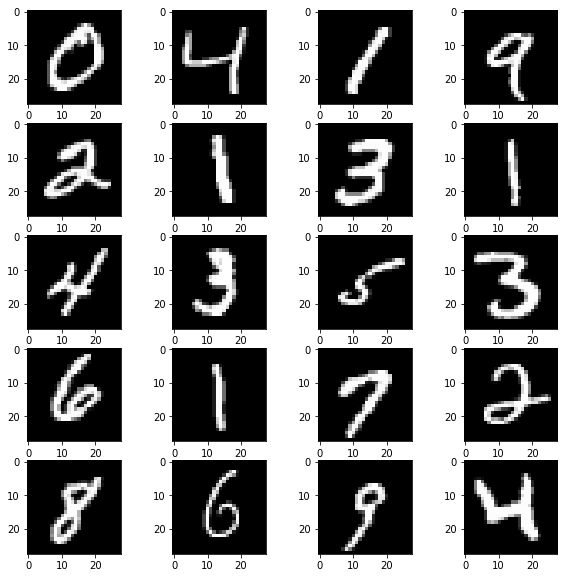

In [10]:
import matplotlib.pyplot as plt
def plot_data(data, h=5, w=4, plot_border=True, title=""):
    """ Plot the given image data.
    
    Args:
        h, w: The number of images per col/row.
        plot_border: if True, plot the axes, if False don't.
        title: Title for the plot.
    """
    # useful functions: plt.subplot, plt.suptitle
    # START TODO ################
    #raise NotImplementedError
    
    fig,ax= plt.subplots(nrows=h,ncols=w,figsize=(10,10))
    
    #for i in range(20):
    i=0
    for row in ax:
        for col in row:
            i=i+1
            img=data[i][0][:,:]
            #col.set_xlabel((np.argmax(data[i][0], axis=-1)))
            col.imshow(img,cmap='gray')
    

    # End TODO ################
plot_data(x_train, h=5, w=4, plot_border=False, title="Traning data")


### Convolution Output Size

The output of the convolution operation depends on the input size ($I$), filter size ($W$), stride ($S$), and padding ($P$). 

**Task:** State the formula for one output dimension.

$ O = \dots \text{TODO} \dots $

**Task:** Implement the formula for arbitrary dimensions.

In [11]:
#import operator
def convnd_output(input_shape: Tuple[int], kernel_size: Tuple[int], 
                  stride: Tuple[int], padding: Tuple[int]) -> Tuple[int]:
    assert len(input_shape) == len(kernel_size) == len(stride) == len(padding),\
        "All inputs need to be of the same length."
    # output = tuple()
    # START TODO ################
    
    #for i in range(2):
        #output[i-1]=(input_shape[i-1] - kernel_size[i-1]+2*padding[i-1])/stride[i-1]+1
        
    #output[0]=(input_shape[0] - kernel_size[0]+2*padding[0])/stride[0]+1   
    #output[1]=(input_shape[1] - kernel_size[1]+2*padding[1])/stride[1]+1 
    #print(output[0])
    #print(output[1])
    
    #tuple(map(operator.delitemmap(operator.add,map(operator.sub,input_shape,kernel_size),map(operator.mul,2,padding))))
    output = tuple(map(lambda a,b,c,d:((a-b+2*c)/d)+1,input_shape,kernel_size,padding,stride))  
    #print(output)
    # End TODO ################
    return (output)


np.testing.assert_equal(
    convnd_output(input_shape=(11, 11), kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
    (9, 9))
np.testing.assert_equal(
    convnd_output(input_shape=(11, 11), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    (11, 11))
np.testing.assert_equal(
    convnd_output(input_shape=(11, 11), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
    (6, 6))

### Your Feedback on Exercise 4.1

TODO

## ConvLayer Implementation

In this exercise, you have to implement your own convolutional layer, **which actually computes cross correlation. This is to ensure compatibility with pytorch.**
Don't forget to run the *gradient check*. Additional we verify against the pytorch convolution implementation.
Input dimensions for the 2d conv layer are $(\text{batch}, \text{channel}, \text{width}, \text{height})$.

*Tipp 1:* Work iteratively. E.g first implement simple convolution, add stride and padding afterwards. 

*Tipp 2:* To keep the implementation fast, don't use more than two for-loops in the convolution. [Broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html) over channels can be helpful here.


In [12]:
class Conv2d(Module):
    """2D convolution (cross correlation to be precise)."""

    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: Tuple[int], stride: Tuple[int] = (1, 1),
                 padding: Tuple[int] = (0, 0)):
        super().__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = padding
        w = np.random.randn(out_channels, in_channels, *kernel_size) * 0.1
        self.W = Parameter(w, name="conv_filter")
        self.b = Parameter(np.zeros((out_channels, 1, 1)), name="conv_bias")
        
    def convolve_(x,filters,height,width):
        f_map=np.zeros_like(height,width)
        for h in range(height):
            for w in range(width):
                x_slice=x[:,:,h:h+self.kernel_size[0],w:w+self.kernel_size[0]]
                f_map[h,w]=np.sum(filters * x_slice)
        return f_map
        
    def __repr__(self) -> str:
        return ("Conv2d(in={},out={},"
                "kernel={},stride={},pad={})"
        .format(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.pad))

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 4
        feature_map = np.empty(self._compute_output_shape(x.shape))
        
        # START TODO ################
        x=np.pad(x,((0,0),(0,0),(self.pad),(self.pad)),'constant',constant_values=0)
        self.input_cache= x

        #print("x shape:",x.shape)      
        #print("filter:",self.W.data)
        
        (height,width)=(feature_map.shape[2],feature_map.shape[3])
        for filter_num in range(self.W.data.shape[0]):
            #for depth in range(self.W.data.shape[1]):
                #f_map=np.zeros_like((height,width))
                for h in range(height):
                    for w in range(width):
                       # if self.stride[0]>1 :
                          #  print("indices:",h,w)
                        x_slice=x[:,:,h*self.stride[0]:h*self.stride[0]+self.kernel_size[0],
                                  w*self.stride[1]:w*self.stride[1]+self.kernel_size[0]]
                        #print("dimensions of multiplication:-------",x_slice.shape,self.W.data[filter_num,:,:,:].shape)
                        #if self.stride[0]>1 :
                           # print("index of feature map -------",h,w)
                        feature_map[:,filter_num,h,w]=np.sum(x_slice*self.W.data[filter_num,:,:,:],axis=(1,2,3))
                #feature_map[:,filter_num,:,:]+=f_map
        #print("feature map:",feature_map)
        return feature_map  # + ... 
        # End TODO ################
        
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        flipped_W = self.W.data[:,:,:,:]
        np.flip(flipped_W,axis=2)
        np.flip(flipped_W,axis=3)
        (height,width)=(self.W.grad.shape[2],self.W.grad.shape[3])

        #print("input_cache shape:",x.shape)
        # START TODO ################
        #(height,width)=(self.W.grad.shape[2],self.W.grad.shape[3])
        print("gradient shape:",grad.shape)
        #print("gradient matrix:",grad)
        #print("flipped weight matrix:",flipped_W)
 
        for filter_num in range(self.W.data.shape[0]): 
            for h in range(height):
                for w in range(width):
                    #print("gradient shape:",grad.shape)
                    #print("indices:",h,w)
                    #print("array indices:",h+grad.shape[2],w+grad.shape[3])
                    x_slice=x[:,:,h:h+grad.shape[2],w:w+grad.shape[3]]  
                    x_slice=np.transpose(x_slice,[1,0,2,3])
                    #print("x slice transpose shape:",x_slice.shape)
                    #print("sum shape:",np.sum(x_slice*grad[:,filter_num,:,:], axis=(1,2,3)).shape)
                    self.W.grad[filter_num,:,h,w]+=np.sum(x_slice*grad[:,filter_num,:,:], axis=(1,2,3))     
        
       
        grad_r=np.zeros((x.shape))
        #print("gradient r shape:",grad_r.shape)
        
        new_index=self.stride[0]*(x.shape[2]-1)+self.W.data.shape[2]
        
        pad_index=int((new_index-grad.shape[2])/2)
        
        #offset=[pad_index,pad_index,pad_index,pad_index]
        
        new_grad=np.pad(grad,((0,0),(0,0),(pad_index,pad_index),(pad_index,pad_index)),'constant',constant_values=0)
        #print("new grad shape",new_grad.shape)

        (height,width)=(grad.shape[2],grad.shape[3]) 
        #print("skgerkheilr",height,width)
        f=self.kernel_size[0]
        for n in range(x.shape[0]):
            for h in range(height):
                for w in range(width):
                    for k in range(self.W.data.shape[0]):
                        ht= h * self.stride[0]
                        wd= w * self.stride[1]
                        grad_slice=new_grad[:,:,h:h+f,w:w+f]
                        #print("in backward pass- indices of grad_r:",h,h+f,w,w+f)
                        #print("weight shape :",flipped_W[k,:,:,:].shape,"grad_slice shpe:",grad_slice[n,k,:,:].shape)
                        #grad_r[n,:,h:h+f,w:w+f]+=np.sum(flipped_W[k,:,:,:] * grad_slice[n,k,:,:],axis=(1,2))  
                        grad_r[n,:,ht:ht+f,wd:wd+f]+=flipped_W[k,:,:,:] * grad[n,k,h,w]
        grad_r=grad_r[:,:,self.pad[0]:grad_r.shape[2]-self.pad[0],self.pad[1]:grad_r.shape[3]-self.pad[1]]
        return grad_r  
        #return grad
        # END TODO ################

    def parameters(self) -> List[Parameter]:
        return self.W, self.b

    def _compute_output_shape(self, input_shape: Tuple[int]) -> Tuple[int]:
        """Compute the output shape."""
        [out_h, out_w] = convnd_output(input_shape[2:], self.kernel_size, self.stride, self.pad)
        # We never silently pad! Note that usually libraries silently pad for uneven output sizes.
        assert out_h % 1 == 0., "invalid combination of conv parameters"
        assert out_w % 1 == 0., "invalid combination of conv parameters"
        batch_size = input_shape[0]
        return (batch_size, self.out_channels, int(out_h), int(out_w))
    
    

    
    
class Flatten(Module):
    """ Flatten feature dimension to (batch_size, feature_dim, 1).
            
        Note: This layer doesn't exist in pytorch but allows us to create
              the model using `Sequential` only.
    """       
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input_cache = x.shape
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1, 1)
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        old_shape = self.input_cache
        return grad.reshape(old_shape)

In [13]:
def torch_validate_conv2d(conv, x):
    x_torch = torch.tensor(x, requires_grad=True)
    y_torch = nn.functional.conv2d(x_torch, 
                                   torch.from_numpy(conv.W.data),
                                   stride=conv.stride, padding=conv.pad)
    grad_torch = torch.autograd.grad(torch.sum(y_torch), x_torch)
    y_pred = conv(x)
    grad_pred = conv.backward(np.ones_like(y_pred))
    
    #print("printing for comparison")
    #print("from pytorch:")
    #print("gradient shape--",grad_torch[0].shape)
    #print(grad_torch)
    #print("from me :")
    #print("gradient shape--",grad_pred.shape)
    #print(grad_pred)
    
    
    np.testing.assert_allclose(y_pred, y_torch.detach().numpy(), rtol=10e-4,
                               err_msg="Your convolution forward pass is not equal to pytorch.")
    np.testing.assert_allclose(grad_pred, grad_torch[0].numpy(), rtol=10e-4,
                               err_msg="Your convolution backward pass is not equal to pytorch.")


x = np.random.rand(2, 3, 11, 11)
# standard conv
conv = Conv2d(3, 10, (3, 3))
# conv with strides
conv_stride = Conv2d(3, 10, (3, 3), stride=(2, 2))
# conv with padding
conv_pad = Conv2d(3, 10, (3, 3), padding=(1, 1))
# conv with padding and strides
conv_stride_pad = Conv2d(3, 10, (3, 3), stride=(2, 2), padding=(1, 1))


for conv in [conv, conv_stride, conv_pad, conv_stride_pad]:
    print("Check implementation for {} ... ".format(conv), end="")
    conv.check_gradients((x,))
    torch_validate_conv2d(conv, x)
    print("All right!")
print("Done.")

Check implementation for Conv2d(in=3,out=10,kernel=(3, 3),stride=(1, 1),pad=(0, 0)) ... gradient shape: (2, 10, 9, 9)
new grad shape (2, 10, 13, 13)
skgerkheilr 9 9
gradient shape: (2, 10, 9, 9)
new grad shape (2, 10, 13, 13)
skgerkheilr 9 9
gradient shape: (2, 10, 9, 9)
new grad shape (2, 10, 13, 13)
skgerkheilr 9 9
gradient shape: (2, 10, 9, 9)
new grad shape (2, 10, 13, 13)
skgerkheilr 9 9
printing for comparison
from pytorch:
gradient shape-- torch.Size([2, 3, 11, 11])
from me :
gradient shape-- (2, 3, 11, 11)
All right!
Check implementation for Conv2d(in=3,out=10,kernel=(3, 3),stride=(2, 2),pad=(0, 0)) ... gradient shape: (2, 10, 5, 5)
new grad shape (2, 10, 23, 23)
skgerkheilr 5 5
gradient shape: (2, 10, 5, 5)
new grad shape (2, 10, 23, 23)
skgerkheilr 5 5
gradient shape: (2, 10, 5, 5)
new grad shape (2, 10, 23, 23)
skgerkheilr 5 5
gradient shape: (2, 10, 5, 5)
new grad shape (2, 10, 23, 23)
skgerkheilr 5 5
printing for comparison
from pytorch:
gradient shape-- torch.Size([2, 3, 

## Experiments

Now let's finally train our model. Make sure to set the correct input dimensions. 
You can reduce the number of samples to train/validate on with `n_samples`, if training takes too long on your device. Of course reducing the sample number also reduces the validation accuracy.

In [14]:
num_epochs = 10
batch_size = 50
learning_rate = 0.01
momentum = 0.9

kernel_size = (4, 4)
stride = (2, 2)
padding = (1, 1)
channels_one = 5
channels_two = 10

loss_fn = CrossEntropyLoss()

n_samples = 10000  # set up to 50000

# START TODO ################
# model = Sequential(
#     Conv2d( ... ),
#     Relu(),
#     Conv2d( ... ),
#     Relu(),
#     Flatten()
#     Linear( ... ))

# End TODO ################
train(conv_model, loss_fn, optimizer, x_train[:n_samples], y_train[:n_samples],
      x_val[:n_samples], y_val[:n_samples], num_epochs=num_epochs, batch_size=batch_size)
pass  # don't show output of train

NameError: name 'conv_model' is not defined

#### Shift Invariance
Let's now explore an important property of convolutions: shift invariance.
For this, we'll shift the validation data by two pixels to the right and bottom.
Then we'll compare the accuracies of a standard MLP and the convolution model we
trained above on the shifted data.

**What do you observe regarding the accuracies? How can the results be explained?**

**Answer:**

**What could we do to improve the accuracy of the MLP model on the shifted validation set?**

**Answer:**



In [ ]:
loss_fn = CrossEntropyLoss()

n_samples = 10000  # set up to 50000

# START TODO ################
# shift the training data by 'shift' pixels to the right and to the bottom
# hint: you can use np.pad and slicing

# x_val_shifted = ...
# END TODO ################

# As always, visualizing your data is important
# plot the shifted and non shifted data using the function you defined above
plot_data(x_val, h=1, w=4, plot_border=True, title="Validation data.")
plot_data(x_val_shifted, h=1, w=4, plot_border=True, title="Shifted validation data.")


learning_rate = 0.05
momentum = 0.9
linear_units = 30
# START TODO ################
# Train an mlp with the given hyper parameters
# Use the non-shifted validation data for evaluation during training,
# to verify that the model trains well.
# Note that you need to reshape the training and validation data to train an MLP.

# x_val_shifted_mlp = ...
# End TODO ################

print("Accuracy on shifted data using convolutional model: ",
      evaluate(x_val_shifted, y_val, conv_model, loss_fn, batch_size)[0])
print("Accuracy on shifted data using an MLP: ",
      evaluate(x_val_shifted_mlp, y_val, mlp_model, loss_fn, batch_size)[0])

### Your Feedback on Exercise 4.2

TODO